little blubr of javascript to enable sublime key-binding and multiple cursor editing (from the internets)

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import seaborn as sns
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("tutorials rely on cooltools version 0.5.1 or higher,"+
                         "please check your cooltools version and update to the latest")

In [4]:
# this enables editing text in Adobe Illustrator after saving PDFs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [5]:
from cooltools.sandbox import obs_over_exp_cooler
from scipy.sparse import coo_matrix

# Contacts vs distance aka "Expected" figure

The figure made out of 3 panels:
 - left: just an example of an observed heatmap - nice, clean at 1MB for 2 chromosomes
 - middle: example of an expected for all regions present in observed (inter and intra arm, trans)
 - right: also expected, but plotted as an individual P(s) curve for each region and trans-level 

In [6]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


### Left and Middle panels of the figure @1Mb resolution, right panel @10kb ...

In [7]:
# Load a Hi-C map at a 1Mb resolution from a cooler file.
resolution_1Mb = 1_000_000
clr_1Mb = cooler.Cooler(f'{cool_file}::/resolutions/{resolution_1Mb}')

# switch to higher resolution for a second part of the figure
resolution_10kb = 10_000
clr_10kb = cooler.Cooler(f'{cool_file}::/resolutions/{resolution_10kb}')

### Use chromosomal arms as a view...

In [8]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr_1Mb.chromnames)].reset_index(drop=True)
# hg38_arms

### generate data at 1Mb for the first 2 panels ...

In [9]:
# calculate full expected (cis + trans) all at once !
# everyhting is done on arm-level
# trans is aggregated afterwards...
expected_df = obs_over_exp_cooler.expected_full(
    clr_1Mb,
    view_df=hg38_arms,
    smooth_cis=True,
    aggregate_trans=True,
    expected_column_name="expected",
    nproc=4,
)

INFO:root:Done calculating cis expected in 1.607 sec ...
INFO:root:Done calculating trans expected in 0.443 sec ...
INFO:root:Returning combined expected DataFrame.


In [10]:
# helper function to generate expected as a pixel table ... -> move to a file
from cooler.tools import partition
from cooltools.lib.common import (
    assign_supports,
    make_cooler_view
)
def exp_generator(
        clr,
        expected_full,
        view_df=None,
        expected_column_name="expected",
        value_column_name="count",  # how to store output - i.e. expected
        clr_weight_name='weight',
        chunksize = 1_000_000,
    ):
    """
    unnecessarily sophisticated generator of expected pixel-table:
    it generates a table with *ALL* possible coordinates of pixels
    correposnding to a square 'len(clr.bins)*len(clr.bins)' heatmap,
    and merges it with 'expected_full' in a 'view_df' dependent manner.
    
    It also handles 'clr_weight_name' in a correct way.
    Works relatively fast.
    """
    # use the same view that was used to calculate full expected
    if view_df is None:
        view_array = make_cooler_view(clr).to_numpy()
    else:
        view_array = view_df.to_numpy()

    # extract and pre-process cooler bintable
    bins = clr.bins()[:]
    n_bins = len(bins)
    bins["r"] = assign_supports(bins, view_array)  # astype float

    # use balanced data, when clr_weight is provided - otherwise raw counts
    if clr_weight_name:
        weight_col1 = f"{clr_weight_name}1"
        weight_col2 = f"{clr_weight_name}2"
    
    # will be generating "fake" upper triangle pixel table of a square
    # n_bins*n_bins matrix with ALL pixels (no sparsity), in chunks:
    spans = partition(0, n_bins*n_bins, chunksize)
    for span in spans:
        lo, hi = span
        pixel_index = np.arange(lo, hi)
        _rows = pixel_index // n_bins  # bin1_id i.e rows -> pixel_index // n_bins
        _cols = pixel_index % n_bins  # bin2_id i.e cols -> pixel_index % n_bins
        _upper_triangle = (_cols >= _rows)  # upper triangle
        pixels = pd.DataFrame( {
                "bin1_id" : _rows[_upper_triangle],
                "bin2_id" : _cols[_upper_triangle],
        } )
        pixels = cooler.annotate(pixels, bins, replace=False)
        # consider dropping NAs if view_df covers only part of the genome and for "bad" bins
        if clr_weight_name:
            pixels = pixels.dropna( subset=["r1", "r2", weight_col1, weight_col2] )
        else:
            pixels = pixels.dropna( subset=["r1", "r2"] )
        # cast to int, as there are no more NaNs among r1/r2
        pixels = pixels.astype({"r1":int, "r2":int})
        # trans pixels will have "feature"-dist of -1
        pixels["dist"] = -1
        # cis pixels will have "feature"-dist "bind2_id - bin1_id"
        cis_mask = (pixels["chrom1"] == pixels["chrom2"])
        pixels.loc[cis_mask,"dist"] = pixels.loc[cis_mask,"bin2_id"] - pixels.loc[cis_mask,"bin1_id"]
        # merge pixels with the expected
        pixels = pd.merge(
            pixels,
            expected_full[["r1","r2","dist",expected_column_name]],
            how="left",
            on=["r1","r2","dist"],
        )
        pixels = pixels.rename(columns={expected_column_name:value_column_name})
        # yield pixel-table-like chunks of observed over expected
        yield pixels[["bin1_id", "bin2_id", value_column_name]]

In [11]:
# collect exp for chunks of pixel table (in memory for 1Mb cooler)
exp_results = []
for _chunk in exp_generator(
        clr_1Mb,
        expected_df,
        view_df=hg38_arms,
        expected_column_name="expected",
        value_column_name='oe',
        chunksize=1_000_000,
    ):
    exp_results.append(_chunk)
# concat chunks into single DataFrame - res_df - is a new pixel table - sparse matrix
exp_res_df = pd.concat(exp_results, ignore_index=True)

# turn it back into dense symmetric heatmap:
# exp_res_df: sparse matrix -> dense matrix for plotting
N = len(clr_1Mb.bins())
emat = coo_matrix(
    (exp_res_df["oe"], (exp_res_df["bin1_id"], exp_res_df["bin2_id"])),
    shape=(N,N),
).toarray()
# make it symmetric ...
emat_1Mb = emat + emat.T
# prepare observed as well
omat_1Mb = clr_1Mb.matrix()[:]
# print(f"generated symmetrix exp matrix of size {N} X {N}")

In [12]:
def filter_badbins_mask(filtered_mask, threshold_size=2):
    """
    function to modify mask of filtered bins
    allows up to hide annoying 1-bins wide filtered bins
    i.e. we keep only wide filtered regions, e.g centrometric ones
    useful for visualization clarity
    """
    # initialize filtered mask to return
    updated_mask = np.zeros_like(filtered_mask)
    # indices of bins to be filtered ... in the beginning
    masked_idx, = filtered_mask.nonzero()
    idx_diff = np.diff(masked_idx)
    # #####################################################################
    # deal with singletons and longer stretches of filtered bins separately
    # #####################################################################
    # (1) singletons ...
    singleton_mask = ~np.logical_or(
        np.r_[idx_diff==1, False],
        np.r_[False, idx_diff==1]
    )
    singleton_idxs = masked_idx[singleton_mask]
    # mask singletons
    updated_mask[singleton_idxs] = True
    #
    # (2) longer stretches of filtered bins ...
    if threshold_size > 1:
        edges_mask = np.logical_xor(
            np.r_[idx_diff==1, False],
            np.r_[False, idx_diff==1]
        )
        edges_idxs = masked_idx[edges_mask]
        # assert len(edges_idxs) % 2 == 0 !!!
        for stretch_start, stretch_end in zip(edges_idxs[::2], edges_idxs[1::2]):
            stretch_length = stretch_end - stretch_start + 1
            if stretch_length <= threshold_size:
                # mask stretch of filtered bins shorter threshold_size
                updated_mask[stretch_start:stretch_end+1] = True
    return updated_mask

In [13]:
# # plot observed and stitched obs/exp side by side
# istart, iend = 0, 300
# mask of balanced out bins
mask = np.nansum(emat_1Mb, axis=0)==0
mask = filter_badbins_mask(mask, 2)
# heatmaps to show
obs = omat_1Mb
exp = emat_1Mb
size, _ = obs.shape  # capture matrix size
# apply mask - to avoid showing empty bins
obs = obs[:,~mask][~mask,:]
exp = exp[:,~mask][~mask,:]
size_masked, _ = obs.shape  # capture size of a masked matrix

### generate coordinate of arrows to draw on an expected heatmap

In [14]:
arrow_coords = []
arrow_len = 0.08*size_masked
for arm in hg38_arms.itertuples(index=False):
    chrom, start, end, name = arm
    if chrom == "chr2":
        _start, _end = clr_1Mb.extent((chrom,start,end))
        # adjust for the masked bins
        _start = _start - mask[:_start].sum()
        _end = _end - mask[:_end].sum()
        # draw mid arrow:
        _mid = (_start + _end)/2
        arrow_coords.append((_mid,_mid, arrow_len, -arrow_len))
        if name == "chr2_p":
            arrow_coords.append((_end,_end, arrow_len, -arrow_len))


### generate list of patch to apply to axes to draw chromosomal arms

In [15]:
# # Draw chromosomal arms around heatmaps ...
def generate_arm_cartoons(ax, clr, mask, pad = 0.015, p_color="black", q_color="silver"):
    _trans_norm = 1/((~mask).sum())
    for arm in hg38_arms.itertuples(index=True):
        idx, chrom, start, end, name = arm
        _start, _end = clr.extent((chrom,start,end))
        # adjust for the masked bins
        _len = _end - _start
        _len = _len - mask[_start:_end].sum()
        _start = _start - mask[:_start].sum()
        _end = _end - mask[:_end].sum()
        
        kwargs = {
            "facecolor" : p_color if idx%2 else q_color,
            "clip_on" : False,
            "linewidth" : 1,
            "boxstyle" : mpl.patches.BoxStyle("Round", pad=pad),
            "transform" : ax.transAxes,
        }
    
        # horizontal arms
        rect = mpl.patches.FancyBboxPatch(
            (_start*_trans_norm+pad, 1+3*pad),
            _len*_trans_norm-2*pad,
            pad,
            **kwargs,
        )
        yield rect

        # vertical arms
        rect = mpl.patches.FancyBboxPatch(
            (-4*pad, 1-_start*_trans_norm-_len*_trans_norm+pad),
            pad,
            _len*_trans_norm-2*pad,
            **kwargs,
        )
        yield rect

## Generate data for the right panel - P(s) @ 10kb

In [16]:
# calculate full expected (cis + trans)
expected_df = obs_over_exp_cooler.expected_full(
    clr_10kb,
    view_df=hg38_arms,
    smooth_cis=True,
    aggregate_trans=True,
    expected_column_name="expected",
    ignore_diags=2,
    nproc=4,
)
# separation: bins -> genomic coords
expected_df['s_bp'] = expected_df['dist'] * resolution_10kb
# clean up short distnaces ... in smoothed section
expected_df['balanced.avg.smoothed'].loc[
    (expected_df['dist'] < 2) & (expected_df['dist'] > -1)
] = np.nan

INFO:root:Done calculating cis expected in 21.219 sec ...
INFO:root:Done calculating trans expected in 12.430 sec ...
INFO:root:Returning combined expected DataFrame.


## Manuscript Figure

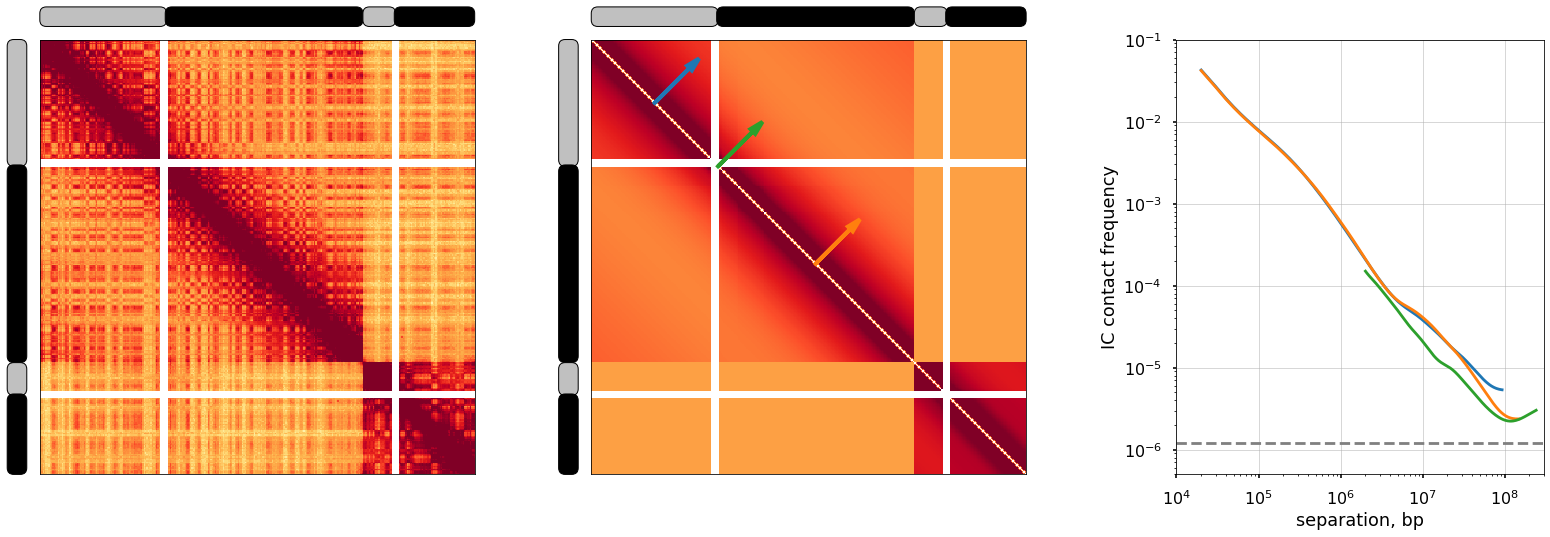

In [17]:
################################
# left and right panels first
#################################
f,axs = plt.subplots(1,3,figsize=(28,8),facecolor="white")

img = axs[0].imshow(
    obs,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01),
    extent=(0,size_masked,size_masked,0)
)
# plt.colorbar(img,ax=axs[0],orientation="horizontal")

img = axs[1].imshow(
    exp,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01),
    origin="upper",
    extent=(0,size_masked,size_masked,0)
)
# plt.colorbar(img,ax=axs[1],orientation="horizontal")

for ax in axs[:2]:
    ax.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False,
        )

# draw 3 arrows:
# _colors = ["orange","green","blue"]
_colors = [sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[1]]
arrow_len = 0.08*size_masked
for idx, (x, y, dx, dy) in enumerate(arrow_coords):
    axs[1].arrow(x, y, dx=arrow_len, dy=-arrow_len, lw=4, head_width=5, head_length=10, fc=_colors[idx], ec=_colors[idx])

# # Draw chromosomal arms around heatmaps ...
for arm_path in generate_arm_cartoons(axs[0],clr=clr_1Mb,mask=mask):
    axs[0].add_patch(arm_path)
for arm_path in generate_arm_cartoons(axs[1],clr=clr_1Mb,mask=mask):
    axs[1].add_patch(arm_path)


###############################
# right panel with P(s) ...
###############################
        
# plot intra-arm P(s) for chr2:
for arm in ['chr2_p', 'chr2_q']:
    _intra_arm_mask = (expected_df['region1']==arm) \
                & (expected_df['region2']==arm)
    axs[2].loglog(
        expected_df.loc[_intra_arm_mask, 's_bp'],
        expected_df.loc[_intra_arm_mask, 'balanced.avg.smoothed'],
    )

# now, inter-arm P(s) for chr2:
_inter_arm_mask = (expected_df["region1"] == 'chr2_p') \
        & (expected_df["region2"] == 'chr2_q') \
        & (expected_df['s_bp']>2e6) # excluding the 2Mb region around the centromere due to sparsity of the data
axs[2].loglog(
    expected_df.loc[_inter_arm_mask, 's_bp'],
    expected_df.loc[_inter_arm_mask, 'balanced.avg.smoothed'],
)

# grab a trans value - 4 identical ones, after aggregation:
_trans_level = expected_df[ 
    (expected_df["region1"].str.startswith("chr2")) 
    & (expected_df["region2"].str.startswith("chr17"))
]["balanced.avg.agg"].iat[0]
axs[2].axhline( _trans_level, ls='--', color='gray')

axs[2].set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
axs[2].set(
    aspect=1.0,
    ylim=(5e-7, 1e-1),
    xlim=(2e4, 3e8)
)
axs[2].grid(lw=0.5)
axs[2].set_xticks(10**np.arange(4,8.1));
plt.savefig("figure_expected.png", bbox_inches="tight")